In [ ]:
!pip install surprise

import pandas as pd
from collections import defaultdict
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import KFold
from surprise import Reader
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from statistics import mean
from matplotlib.ticker import MaxNLocator

In [617]:
url_movies = 'https://raw.githubusercontent.com/rodrigotavio91/tcc/main/dataset/ml-1m/movies.dat'
url_users = 'https://raw.githubusercontent.com/rodrigotavio91/tcc/main/dataset/ml-1m/users.dat'
url_ratings = 'https://raw.githubusercontent.com/rodrigotavio91/tcc/main/dataset/ml-1m/ratings.dat'

df_movies = pd.read_csv(url_movies, sep='::', encoding='cp1252', engine='python', names=['MovieID', 'Title', 'Genres'])
df_users = pd.read_csv(url_users, sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Ocupation', 'Zip-code'])
df_ratings = pd.read_csv(url_ratings, sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [618]:
# Append user and movie data to ratings
df = df_ratings.join(df_users.set_index('UserID'), rsuffix='_', on='UserID').join(df_movies.set_index('MovieID'), rsuffix='_', on='MovieID')
df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Ocupation,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


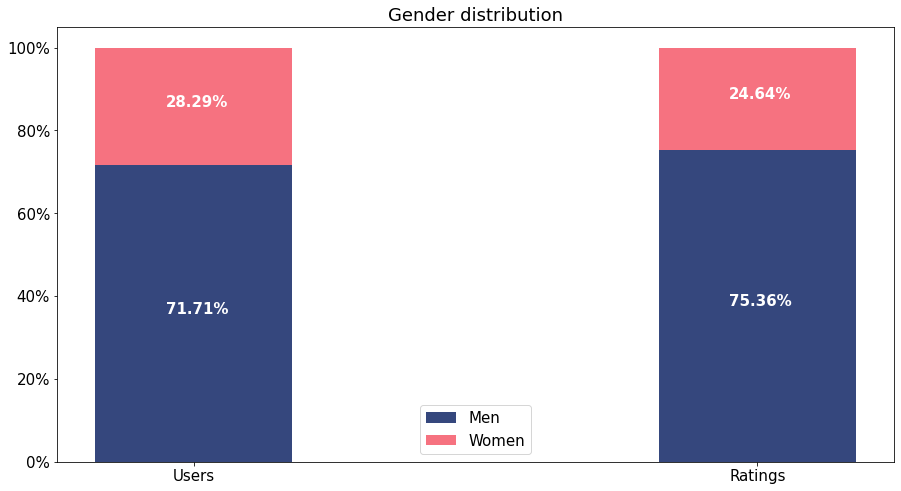

In [619]:
labels = ['Users', 'Ratings']
men_count = df_users.loc[df_users['Gender'] == 'M'].shape[0]
men_perc = men_count / df_users.shape[0] * 100

women_count = df_users.loc[df_users['Gender'] == 'F'].shape[0]
women_perc = women_count / df_users.shape[0] * 100

men_ratings_count = df.loc[df['Gender'] == 'M'].shape[0]
men_ratings_perc = men_ratings_count / df.shape[0] * 100

women_ratings_count = df.loc[df['Gender'] == 'F'].shape[0]
women_ratings_perc = women_ratings_count / df.shape[0] * 100

plt.rc('font', size=15)  
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, [men_perc, men_ratings_perc], width, label='Men', color='#35477d')
rects2 = ax.bar(x, [women_perc, women_ratings_perc], width, label='Women', color='#f67280', bottom=[men_perc, men_ratings_perc])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Gender distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.legend()

for rect in rects1:  
  xloc = rect.get_x() + rect.get_width() / 2 - 0.05  
  yloc = rect.get_y() + rect.get_height() / 2
  ax.annotate('{}%'.format(round(rect.get_height(), 2)), xy=(xloc, yloc),
              color='white', weight='bold')
  
for rect in rects2:  
  xloc = rect.get_x() + rect.get_width() / 2  - 0.05
  yloc = rect.get_y() + rect.get_height() / 2
  ax.annotate('{}%'.format(round(rect.get_height(), 2)), xy=(xloc, yloc),
              color='white', weight='bold')


fig.set_figwidth(15)
fig.set_figheight(8)


plt.show()

In [620]:

# genres = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
genres = ["Romance", "Action", "Sci-Fi", "Musical", "Crime"]

women_genre_ratings = []
women_genre_frequency = []
women_mean_ratings = []
women_frequency = []

men_genre_ratings = []
men_genre_frequency = []
men_mean_ratings = []
men_frequency = []

for genre in genres:  
  ratings = df.loc[(df['Genres'].str.contains(genre)) & (df['Gender'] == 'F')]['Rating']
  women_genre_ratings.append(ratings.tolist())
  women_mean_ratings.append(round(ratings.mean(), 2))

  ratings = df.loc[(df['Genres'].str.contains(genre)) & (df['Gender'] == 'M')]['Rating']
  men_genre_ratings.append(ratings.tolist())
  men_mean_ratings.append(round(ratings.mean(), 2))

  frequency = df.loc[(df['Genres'].str.contains(genre)) & (df['Gender'] == 'F')].groupby(['UserID']).count()['Rating']
  women_genre_frequency.append(frequency.tolist())
  women_frequency.append(round(frequency.mean(), 2))

  frequency = df.loc[(df['Genres'].str.contains(genre)) & (df['Gender'] == 'M')].groupby(['UserID']).count()['Rating']
  men_genre_frequency.append(frequency.tolist())
  men_frequency.append(round(frequency.mean(), 2))


print(women_mean_ratings)
print(men_mean_ratings)
print(women_frequency)
print(men_frequency)

[3.67, 3.49, 3.45, 3.81, 3.69]
[3.57, 3.49, 3.47, 3.6, 3.71]
[29.62, 26.96, 16.75, 9.71, 10.49]
[22.81, 49.04, 30.38, 8.33, 15.41]


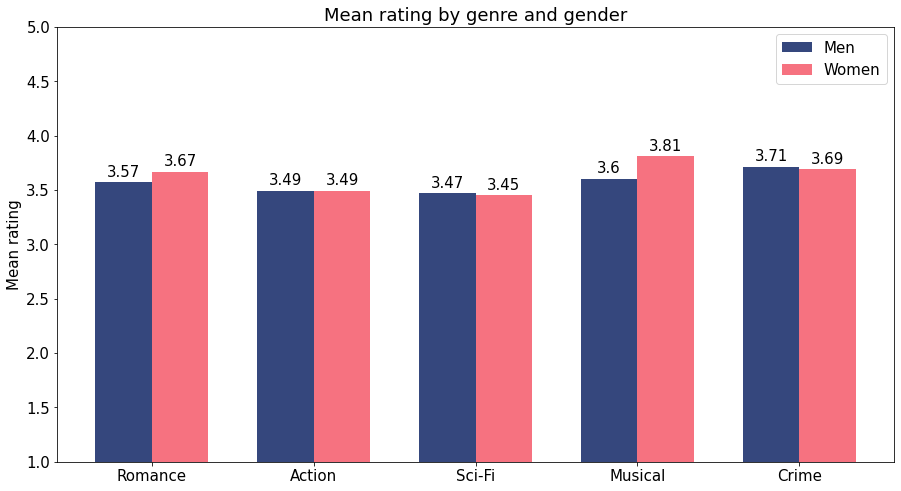

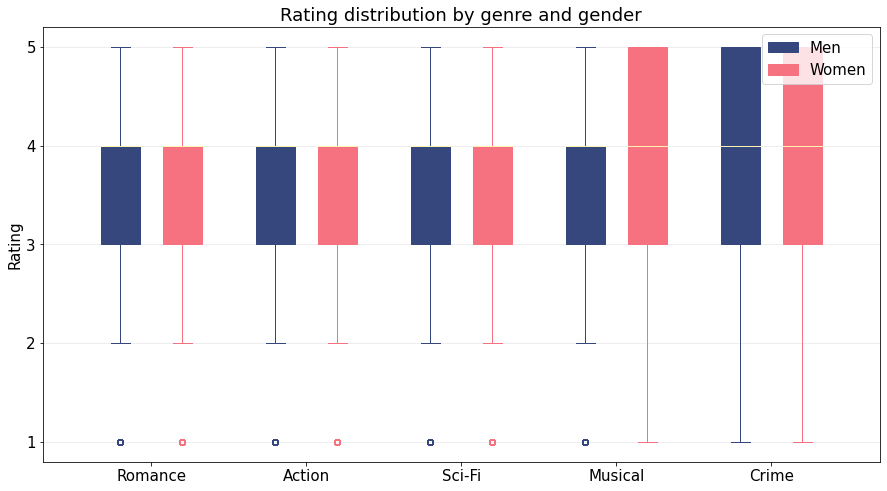

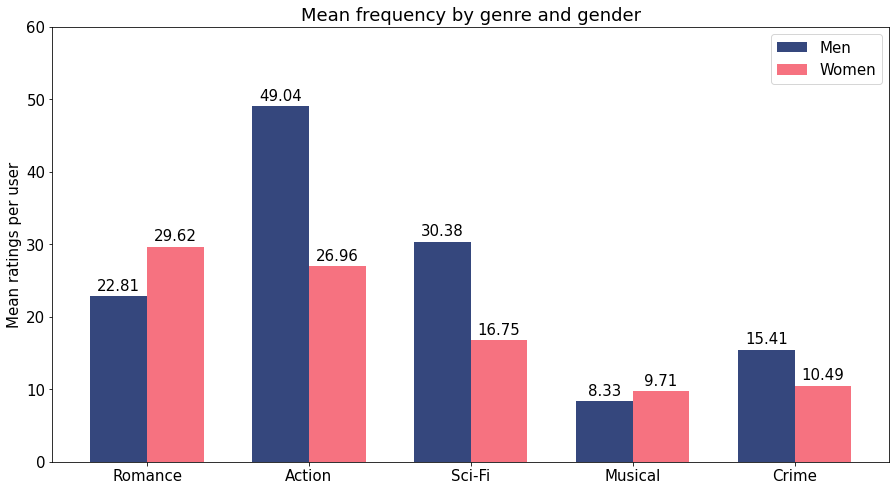

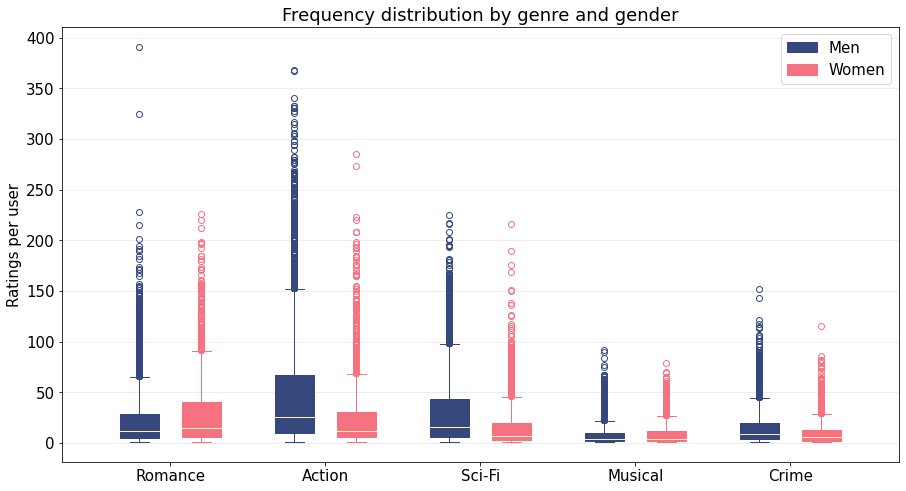

In [651]:
def autolabel(rects, ax):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

def bar_plot(labels, women_data, men_data, title, ylabel, lower, upper):    
  plt.rc('font', size=15) 
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, men_data, width, label='Men', color='#35477d')
  rects2 = ax.bar(x + width/2, women_data, width, label='Women', color='#f67280')
  

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(ylabel)
  ax.set_ybound(lower=lower, upper=upper)
  ax.set_title(title)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()


  autolabel(rects1, ax)
  autolabel(rects2, ax)

  
  fig.set_figwidth(15)
  fig.set_figheight(8)

  plt.show()

def box_plot(labels, women_data, men_data, title, ylabel, yticks = None):  
  x = np.arange(len(labels))  # the label locations
  width = 0.25

  c1 = '#35477d'
  c2 = '#f67280'
  fig1, ax1 = plt.subplots(figsize=(15, 8))
  ax1.set_title(title)

  ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)
  
  bp = ax1.boxplot(np.array(men_data, dtype='object'), widths=(width), positions=x - width + 0.05,
                  patch_artist=True, 
                  boxprops=dict(facecolor=c1, color=c1),
                  capprops=dict(color=c1),
                  whiskerprops=dict(color=c1),
                  flierprops=dict(color=c1, markeredgecolor=c1),
                  medianprops=dict(color='#fff3af'))

  bp2 = ax1.boxplot(np.array(women_data, dtype='object') , widths=(width), positions=x + width - 0.05,
                    patch_artist=True,
                    boxprops=dict(facecolor=c2, color=c2),
                    capprops=dict(color=c2),
                    whiskerprops=dict(color=c2),
                    flierprops=dict(color=c2, markeredgecolor=c2),
                    medianprops=dict(color='#fff3af'))

  ax1.set_ylabel(ylabel)  
  ax1.set_xticks(x)  
  ax1.set_xticklabels(labels)
  if yticks:
    ax1.set_yticks([1, 2, 3, 4, 5])
  ax1.legend([bp["boxes"][0], bp2["boxes"][0]], ['Men', 'Women'], loc='upper right')

fig1.show()

bar_plot(genres, women_mean_ratings, men_mean_ratings, 'Mean rating by genre and gender',  'Mean rating', 1, 5)
box_plot(genres, women_genre_ratings, men_genre_ratings, 'Rating distribution by genre and gender', 'Rating', yticks=True)

bar_plot(genres, women_frequency, men_frequency, 'Mean frequency by genre and gender', 'Mean ratings per user', 0, 60)
box_plot(genres, women_genre_frequency, men_genre_frequency, 'Frequency distribution by genre and gender', 'Ratings per user')



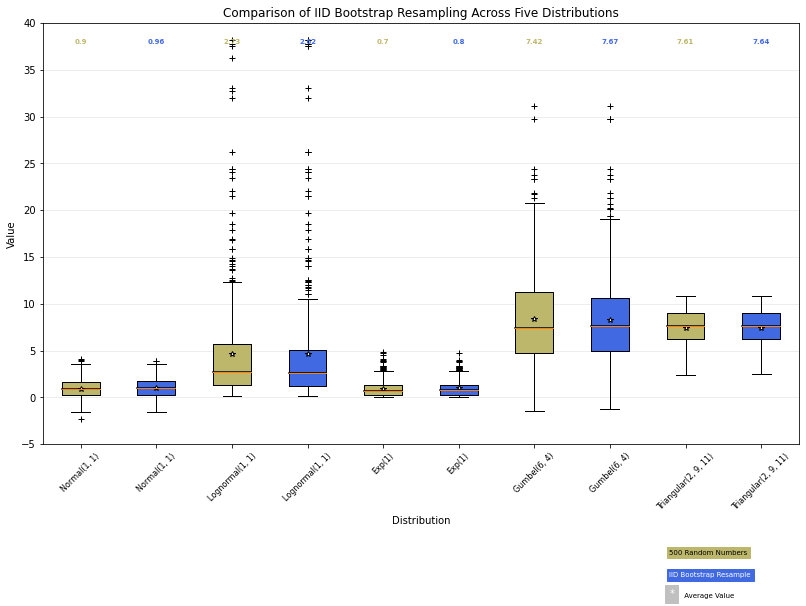

In [ ]:
random_dists = ['Normal(1, 1)', 'Lognormal(1, 1)', 'Exp(1)', 'Gumbel(6, 4)',
                'Triangular(2, 9, 11)']
N = 500

norm = np.random.normal(1, 1, N)
logn = np.random.lognormal(1, 1, N)
expo = np.random.exponential(1, N)
gumb = np.random.gumbel(6, 4, N)
tria = np.random.triangular(2, 9, 11, N)

# Generate some random indices that we'll use to resample the original data
# arrays. For code brevity, just use the same random indices for each array
bootstrap_indices = np.random.randint(0, N, N)
data = [
    norm, norm[bootstrap_indices],
    logn, logn[bootstrap_indices],
    expo, expo[bootstrap_indices],
    gumb, gumb[bootstrap_indices],
    tria, tria[bootstrap_indices],
]

fig, ax1 = plt.subplots(figsize=(12, 9))
fig.canvas.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Comparison of IID Bootstrap Resampling Across Five Distributions',
    xlabel='Distribution',
    ylabel='Value',
)

# Now fill the boxes with desired colors
box_colors = ['darkkhaki', 'royalblue']
num_boxes = len(data)
medians = np.empty(num_boxes)
for i in range(num_boxes):
    box = bp['boxes'][i]
    box_x = []
    box_y = []
    for j in range(5):
        box_x.append(box.get_xdata()[j])
        box_y.append(box.get_ydata()[j])
    box_coords = np.column_stack([box_x, box_y])
    # Alternate between Dark Khaki and Royal Blue
    ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    median_x = []
    median_y = []
    for j in range(2):
        median_x.append(med.get_xdata()[j])
        median_y.append(med.get_ydata()[j])
        ax1.plot(median_x, median_y, 'k')
    medians[i] = median_y[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
             color='w', marker='*', markeredgecolor='k')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, num_boxes + 0.5)
top = 40
bottom = -5
ax1.set_ylim(bottom, top)
ax1.set_xticklabels(np.repeat(random_dists, 2),
                    rotation=45, fontsize=8)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(num_boxes) + 1
upper_labels = [str(round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], .95, upper_labels[tick],
             transform=ax1.get_xaxis_transform(),
             horizontalalignment='center', size='x-small',
             weight=weights[k], color=box_colors[k])

# Finally, add a basic legend
fig.text(0.80, 0.08, f'{N} Random Numbers',
         backgroundcolor=box_colors[0], color='black', weight='roman',
         size='x-small')
fig.text(0.80, 0.045, 'IID Bootstrap Resample',
         backgroundcolor=box_colors[1],
         color='white', weight='roman', size='x-small')
fig.text(0.80, 0.015, '*', color='white', backgroundcolor='silver',
         weight='roman', size='medium')
fig.text(0.815, 0.013, ' Average Value', color='black', weight='roman',
         size='x-small')

plt.show()


In [ ]:
def predictions_to_dataframe(predictions):
  df = pd.DataFrame(list(map(lambda x: {'UserID': x.uid, 'MovieID': x.iid, 'Rating': x.r_ui, 'Prediction': x.est}, predictions)))  
  return df.join(df_users.set_index('UserID'), rsuffix='_', on='UserID').join(df_movies.set_index('MovieID'), rsuffix='_', on='MovieID')

def parity_metric(df):
  women_mean_prediction = df.loc[df['Gender'] == 'F']['Prediction'].mean()
  men_mean_prediction = df.loc[df['Gender'] == 'M']['Prediction'].mean()
  return abs(women_mean_prediction - men_mean_prediction)

def value_unfairness(df):
  women_df = df.loc[df['Gender'] == 'F'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]  
  women_df['Women_Diff'] = women_df['Prediction'] - women_df['Rating']

  men_df = df.loc[df['Gender'] == 'M'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]
  men_df['Men_Diff'] = men_df['Prediction'] - men_df['Rating']

  df_full = women_df.join(men_df.set_index('MovieID'), rsuffix='_', on='MovieID')
  df_full['Diff'] = abs(df_full['Women_Diff'] - df_full['Men_Diff'])

  return df_full['Diff'].sum() / df_full.shape[0]

def absolute_unfairness(df):
  women_df = df.loc[df['Gender'] == 'F'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]  
  women_df['Women_Diff'] = abs(women_df['Prediction'] - women_df['Rating'])

  men_df = df.loc[df['Gender'] == 'M'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]
  men_df['Men_Diff'] = abs(men_df['Prediction'] - men_df['Rating'])

  df_full = women_df.join(men_df.set_index('MovieID'), rsuffix='_', on='MovieID')
  df_full['Diff'] = abs(df_full['Women_Diff'] - df_full['Men_Diff'])

  return df_full['Diff'].sum() / df_full.shape[0]

def underestimation(df):
  women_df = df.loc[df['Gender'] == 'F'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]  
  women_df['Women_Diff'] = women_df['Rating'] - women_df['Prediction']
  women_df.loc[women_df['Women_Diff'] < 0, 'Women_Diff'] = 0  

  men_df = df.loc[df['Gender'] == 'M'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]
  men_df['Men_Diff'] = men_df['Rating'] - men_df['Prediction']
  men_df.loc[men_df['Men_Diff'] < 0, 'Men_Diff']  = 0

  df_full = women_df.join(men_df.set_index('MovieID'), rsuffix='_', on='MovieID')
  df_full['Diff'] = abs(df_full['Women_Diff'] - df_full['Men_Diff'])

  return df_full['Diff'].sum() / df_full.shape[0]

def overestimation(df):
  women_df = df.loc[df['Gender'] == 'F'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]  
  women_df['Women_Diff'] = women_df['Prediction'] - women_df['Rating'] 
  women_df.loc[women_df['Women_Diff'] < 0, 'Women_Diff'] = 0

  men_df = df.loc[df['Gender'] == 'M'].groupby('MovieID').mean().reset_index()[['MovieID', 'Rating', 'Prediction']]
  men_df['Men_Diff'] = men_df['Prediction'] - men_df['Rating']
  men_df.loc[men_df['Men_Diff'] < 0, 'Men_Diff']  = 0

  df_full = women_df.join(men_df.set_index('MovieID'), rsuffix='_', on='MovieID')
  df_full['Diff'] = abs(df_full['Women_Diff'] - df_full['Men_Diff'])

  return df_full['Diff'].sum() / df_full.shape[0]


In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)

kf = KFold(n_splits=5)
algo = SVD()

rmse = []
parity = []
value = []
absolute = []
under = []
over = []

for trainset, testset in kf.split(data):
  algo.fit(trainset)
  predictions = algo.test(testset)
  df = predictions_to_dataframe(predictions)

  rmse.append(accuracy.rmse(predictions, verbose=False))
  parity.append(parity_metric(df))
  value.append(value_unfairness(df))
  absolute.append(absolute_unfairness(df))
  under.append(underestimation(df))
  over.append(overestimation(df))
  



In [ ]:
scores = {
  'RMSE': round(mean(rmse), 2),
  'Parity': round(mean(parity), 2), 
  'Value Unfairness': round(mean(value), 2),   
  'Absolute Unfairness': round(mean(absolute), 2),   
  'Underestimation': round(mean(under), 2),   
  'Overestimation': round(mean(over), 2),     
}

for k in scores:
  print(k, scores[k])

RMSE 0.87
Parity 0.05
Value Unfairness 0.39
Absolute Unfairness 0.26
Underestimation 0.17
Overestimation 0.21


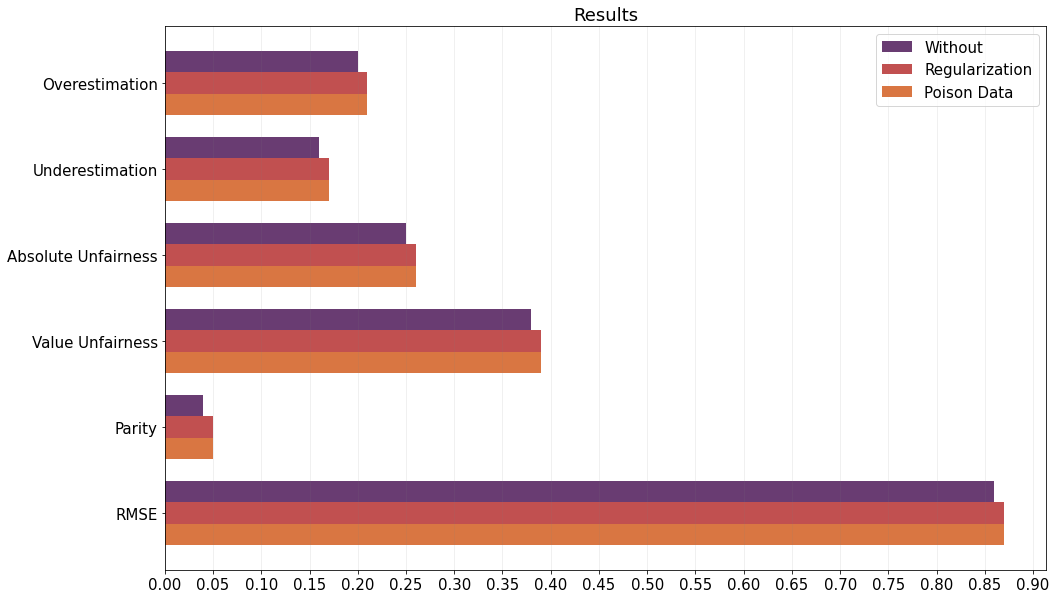

In [ ]:
test_names = [k for k in scores]
width = 0.25
fig, ax1 = plt.subplots(figsize=(16, 10))  # Create the figure
fig.subplots_adjust(left=0.115, right=0.88)

pos = np.arange(len(test_names))

rects = ax1.barh(pos + width, list(map(lambda x: x - 0.01, [scores[k] for k in test_names])),
                  width,
                  color='#693c72',
                  align='center',
                  label='Without',                 
                  tick_label=test_names)
rects = ax1.barh(pos, [scores[k] for k in test_names],
                  width,
                  color='#c15050',
                  align='center',
                  label='Regularization',                 
                  tick_label=test_names)

rects = ax1.barh(pos - width, [scores[k] for k in test_names],
                  width,
                  color='#d97642',
                  align='center',
                  label='Poison Data',                 
                  tick_label=test_names)

#autolabel(rects, ax1)

ax1.set_title('Results')
ax1.xaxis.set_major_locator(MaxNLocator(20))
ax1.xaxis.grid(True, which='major' ,
                   color='grey', alpha=.15)
ax1.set_yticks(pos)
ax1.legend()

fig.show()